## Nearest neighbors
### 是最著名的机器学习算法
### 原理“走路像鸭子，叫声像鸭子，就最可能是鸭子
### 寻找最相似的新的点，之前未知的点
### 当近似点找到后，采用统计方法，计算可能的结果，并以此为交易决策的基础。
### 以下策略为波动性策略，使用2个指标。

In [1]:
# take a look at nearest neighbors of VXX
%pylab inline
import tradingWithPython as twp
import tradingWithPython.lib.yahooFinance as yf
import tradingWithPython.lib.cboe as cboe
from sklearn import neighbors
import pandas as pd
figsize(10,5)
twp.extra.setNotebookStyle()

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda3\lib\site-packages\tradingWithPython\lib\cboe.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##Strategy thesis##

Suppose that next-day returns of VXX can be predicted with two parameters:
### 认为以下两个指标可以用来预测VXX下一个交易日的收益率。
* the steepness of the VIX futures contango or backwardation
* short term return of the VXX

Now we'll create an independant variables dataset $X$, that contains a measure of the futures contango/backwardation (variable $a$) and a running sum of VXX returns (variable $b$).
 $$a=VIX-VXV $$
 $$b=\sum_{i=n-k}^nr_i$$

Where $r$ is the daily return of *VXX*

Of course, the variables in the dataset can be anything (any indicator that you can imagine) and we can have as many of them as we like. Two-dimensional space however does not suffer from the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and is easy to visualise. It is preferable to keep the amount of dimensions to a minimum, but adding extra inputs could increase classifying performance.

The strategy is based on the assumption that
$$r_{i+1} = F(X)+\epsilon $$

Where $F(X)$ is some (unknown) transfer function and $\epsilon$ is noise.
We will use knn algorithm to estimate $F(X)$ and use this estimation for predicting outomes of $r_{i+1}$ for new values of *a* and *b*

##Prepare data##
As usual, we need to prepare the data first.

In [2]:
# get closing prices
vxx = yf.getHistoricData('VXX')['adj_close']
vol = cboe.getHistoricData()

Got 2100 days of data


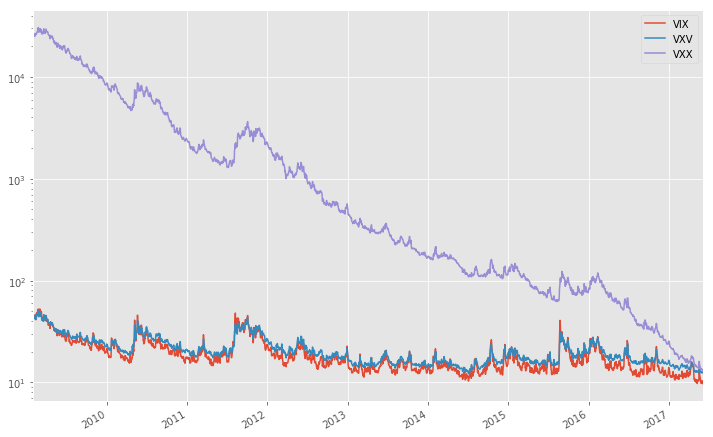

In [3]:
# combine data into one DataFrame
data = pd.DataFrame({'VIX':vol.VIX,'VXV':vol.VXV,'VXX':vxx}).dropna()
data.plot(logy=True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).sum()


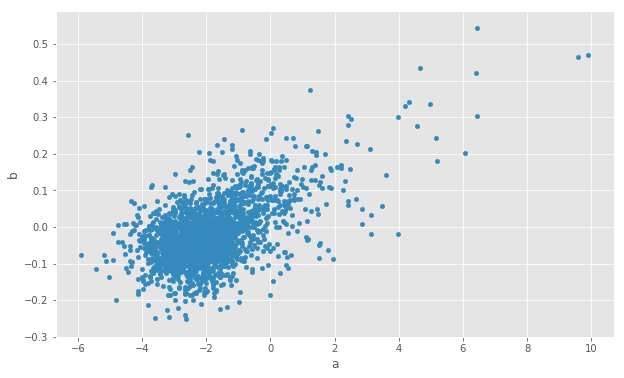

In [4]:
# now we will create dataset X containing independant variables and dataset Y with next-day returns of VXX

k = 5 # lookback for rolling sum of the VXX returns
R = data.VXX.pct_change() # daily returns of VXX

X = pd.DataFrame({'a':data.VIX-data.VXV,'b':pd.rolling_sum(R,k)}) # independent variables dataset,with columns 'a' and 'b'
Y= R.shift(-1) # next-day return

# X and Y at this moment contain some rows with nan values. 
# These will cause problems later on as knn does not handle these well.
# it is a good idea to clean up the missing values, this can be done  on one line.
uniqueIdx = pd.concat((X,Y), axis=1).dropna().index # concatenate X and Y to a joint dataset, drop nans and get index

# reindex X and Y to rows that don't contain nans (removes some rows)

X = X.reindex(uniqueIdx)
Y = Y.reindex(uniqueIdx)
figsize(10, 6)
X.plot(kind='scatter',x='a',y='b') # plot the data


In [5]:
#### 要注意自变量间对额相关性。该例没有问题；
### 要注意自变量的比例。该例比例不一致，需要normalize

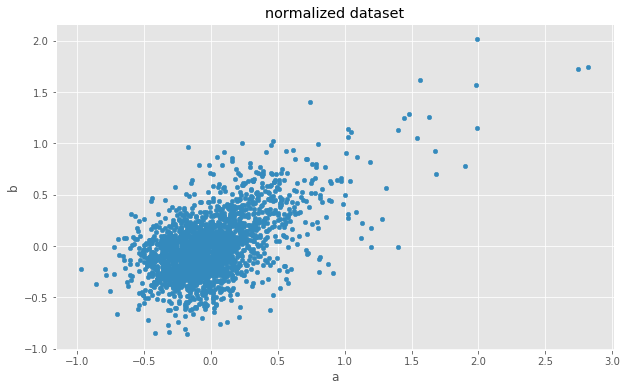

In [6]:
# for normalization we'll create a small class Normalizer:

class Normalizer(object):
    """ normalizes data to zero mean and 5-95 percentiles range"""
    def __init__(self,data):
        # determine mean and range of data based on input dataset 
        # 类似于用数据进行训练，获得各个均值
        self.mean = data.mean(0) # data mean纵向计算
        self.rng = data.quantile(0.95)-data.quantile(0.05) # data range. Quantiles take care of outliers 返回的是位于0.05和0.95分位的值大小
        
    def transform(self,data):
        # normalize input data 输入需要被标准化的数据
        """ normalize dataset """
        return (data-self.mean)/self.rng #数值本身减去序列均值，然后除以某个分位数。直接用data这个df操作，不用逐行逐cell操作。
        
normalizer = Normalizer(X) # create normalizer

Xn =normalizer.transform(X) # Xn will now be the normalized dataset
Xn.plot(kind='scatter',x='a',y='b') # plot the data
title('normalized dataset')

In [35]:
knn = neighbors.NearestNeighbors(20)
knn.fit(Xn) #使用Xn数据对knn进行训练。 
xn = [2, 0.1]
xn =  normalizer.transform(xn)
print('transformed data: x\n', xn)
dist, idx = knn.kneighbors(xn) #选中的离近点到中心点的距离，以及该数据对应的index位置
idx = idx[0]


transformed data: x
 a    0.93
b    0.41
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


C:\Users\User\Anaconda3\lib\site-packages\pandas\tools\plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


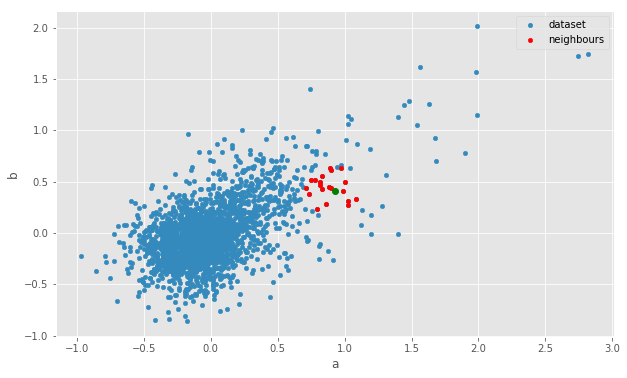

In [49]:
a, b = 'a', 'b'
ax = Xn.plot(kind='scatter', x=a, y=b, label='dataset')
Xn.ix[idx].plot(kind='scatter', x=a, y=b, ax=ax, colors='red', label='neighbours')
plot(xn[0],xn[1], 'go') #直接画一个点儿
plt.grid(True)